In [3]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import json
import torch

# MAKE SURE TO COPY DATA TO /tmp/food-101

RANDOM_SEED = 1994
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True


IMG_SUFFIX = ".jpg"



data_path = Path("/tmp/food-101")

image_path = data_path / "images"
train_path = data_path / "train"
test_path = data_path / "test"
valid_path = data_path / "valid"

dataset = ImageFolder(image_path)

train_json = json.load(open(data_path / "meta" / "train.json"))
test_json = json.load(open(data_path / "meta" / "test.json"))


In [8]:
from collections import OrderedDict

assert set(test_json.keys()) == set(train_json.keys())

def get_class_counts(json):
    counts = OrderedDict()
    for key in json.keys():
        counts[key] = len(json[key])
    return counts

test_counts = get_class_counts(test_json)
train_counts = get_class_counts(train_json)
n_train = sum(train_counts.values())
n_test = sum(test_counts.values())


<BarContainer object of 101 artists>

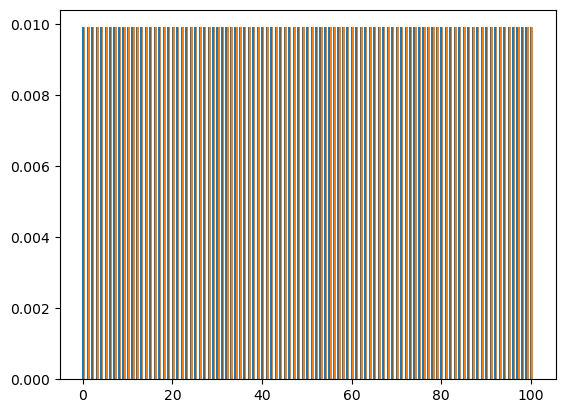

In [9]:
# plot the class distributions side by side
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
bar_width = 0.35
clas = list(test_counts.keys())
x = np.arange(len(clas))
ax.bar(x, np.array(list(train_counts.values()))/n_train, bar_width, label='Train')
ax.bar(x + bar_width, np.array(list(test_counts.values()))/n_test, bar_width, label='Test')

In [10]:
print(set(test_counts.values()))
print(set(train_counts.values()))

{250}
{750}


In [11]:
n_valid_per_class = 105 
np_random = np.random.RandomState(RANDOM_SEED)
def split_train_valid(source_json, n_valid_per_class, np_random):
    train_json = {}
    valid_json = {}
    for key, value in source_json.items():
        np_random.shuffle(value)
        train_json[key] = value[n_valid_per_class:]
        valid_json[key] = value[:n_valid_per_class]
    return train_json, valid_json
    
train_split_json, valid_split_json = split_train_valid(train_json, n_valid_per_class, np_random)

In [12]:
train_split_json_path = data_path / "meta" / "train_split.json"
valid_split_json_path = data_path / "meta" / "valid_split.json"

json.dump(train_split_json, open(train_split_json_path, "w"))
json.dump(valid_split_json, open(valid_split_json_path, "w"))

So the datasets are balanced and the test set represents exactly a third of the train. 
We are going to build a valid json.

In [13]:
def make_image_folder(source_folder, target_folder, class_dict):
    target_folder.mkdir(parents=True, exist_ok=True)

    for class_name, class_images in class_dict.items():
        class_folder = target_folder / class_name
        class_folder.mkdir(parents=True, exist_ok=True)

        for image_name in class_images:
            source_image = (source_folder / image_name).with_suffix(IMG_SUFFIX)
            target_image = (target_folder / image_name).with_suffix(IMG_SUFFIX)
            target_image.symlink_to(source_image)

make_image_folder(image_path, data_path / "train", train_split_json)
make_image_folder(image_path, data_path / "valid", valid_split_json)
make_image_folder(image_path, data_path / "test", test_json)

FileExistsError: [Errno 17] File exists: '/tmp/food-101/images/churros/1285748.jpg' -> '/tmp/food-101/train/churros/1285748.jpg'

In [14]:
train_split_counts = get_class_counts(train_split_json)
valid_split_counts = get_class_counts(valid_split_json)

print(set(train_split_counts.values()))
print(set(valid_split_counts.values()))

{645}
{105}


In [4]:

from PIL import Image
def vizu_one_image_per_class(class_dict, source_folder, transform=None):
    n_row, n_col = 11, 10
    fig, axes = plt.subplots(n_row, n_col, figsize=(20, 20))
    for i, (class_name, class_images) in enumerate(class_dict.items()):
        ax = axes[i // n_col, i % n_col]
        ax.axis("off")
        image_path = source_folder / class_images[0]
        image = Image.open(image_path.with_suffix(IMG_SUFFIX))
        if transform is not None:
            image = transform(image)
        ax.imshow(image)
        ax.set_title(class_name)
        
    
vizu_one_image_per_class(train_split_json, train_path)

NameError: name 'train_split_json' is not defined

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# Define the CNN architecture
class SmallConvNet(nn.Module):
    def __init__(self, num_classes=101):
        super(SmallConvNet, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # Convolutional Block 2 (Depthwise Separable Conv)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, groups=32)  # Depthwise
        self.pointwise1 = nn.Conv2d(64, 64, kernel_size=1, stride=1)  # Pointwise\
        
        # Convolutional Block 3 (Depthwise Separable Conv)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, groups=64)  # Depthwise
        self.pointwise2 = nn.Conv2d(128, 128, kernel_size=1, stride=1)  # Pointwise
        
        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.drop2 = nn.Dropout(0.3)
        
        # Fully Connected Layer
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        
        # Block 2
        x = F.relu(self.pointwise1(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        # Block 3
        x = F.relu(self.pointwise2(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)

        x = self.drop2(x)
        
        # Flatten the tensor
        x = torch.flatten(x, 1)
        
        # Fully Connected Layer
        x = self.fc(x)
        
        return x

In [36]:
from torchsummary import summary
net1 = SmallConvNet(num_classes=101)
summary(net1.cuda(), (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
            Conv2d-2         [-1, 32, 512, 512]           9,248
            Conv2d-3         [-1, 64, 256, 256]             640
            Conv2d-4         [-1, 64, 256, 256]           4,160
            Conv2d-5        [-1, 128, 128, 128]           1,280
            Conv2d-6        [-1, 128, 128, 128]          16,512
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Linear-8                  [-1, 101]          13,029
Total params: 45,765
Trainable params: 45,765
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 224.00
Params size (MB): 0.17
Estimated Total Size (MB): 227.18
----------------------------------------------------------------


In [33]:
class CIFAR10Model(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(2097152, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, num_classes)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

In [34]:
net2 = CIFAR10Model(num_classes=101)
summary(net2.cuda(), (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
              ReLU-2         [-1, 32, 512, 512]               0
           Dropout-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
         MaxPool2d-6         [-1, 32, 256, 256]               0
           Flatten-7              [-1, 2097152]               0
            Linear-8                  [-1, 512]   1,073,742,336
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 101]          51,813
Total params: 1,073,804,293
Trainable params: 1,073,804,293
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3

In [46]:
def get_mean_std_from_datapath(data_path):
    # 1. Define a simple transformation that only converts the images to tensors (without normalization)
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()  # Converts images to PyTorch tensors with pixel values in the range [0, 1]
    ])

    # 2. Load the dataset (replace 'YourDataset' with your actual dataset)
    dataset = ImageFolder(root=data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    # 3. Initialize variables to store the sum and squared sum of pixel values for each channel
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = 0

    # 4. Loop over the dataset to calculate mean and std
    for images, _ in dataloader:
        # Multiply by batch size (images.shape[0]) to get the number of samples in the batch
        n_samples += images.size(0)
        
        # Sum up the pixel values along the batch and spatial dimensions (width and height)
        mean += images.mean([0, 2, 3]) * images.size(0)  # Mean for each channel (R, G, B)
        std += images.std([0, 2, 3]) * images.size(0)    # Standard deviation for each channel

    # 5. Divide by total number of samples to get the mean and std over the entire dataset
    mean /= n_samples
    std /= n_samples

    return mean, std

In [49]:
mean, std = get_mean_std_from_datapath(train_path)

KeyboardInterrupt: 

In [53]:
with open("mean_std.json", "w") as f:
    json.dump({"mean": mean.tolist(), "std": std.tolist()}, f)

In [54]:
def get_mean_std_from_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return torch.tensor(data["mean"]), torch.tensor(data["std"])

In [55]:
mean, std = get_mean_std_from_json("mean_std.json")

In [56]:
print(mean, std)

tensor([0.5451, 0.4435, 0.3438]) tensor([0.2693, 0.2726, 0.2766])


In [64]:
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [65]:
data_augmentation = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [48]:
print(mean, std)

tensor([0.5451, 0.4435, 0.3438]) tensor([0.2693, 0.2726, 0.2766])


In [ ]:
def get_mean_std_from_datapath2(data_path):
        # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

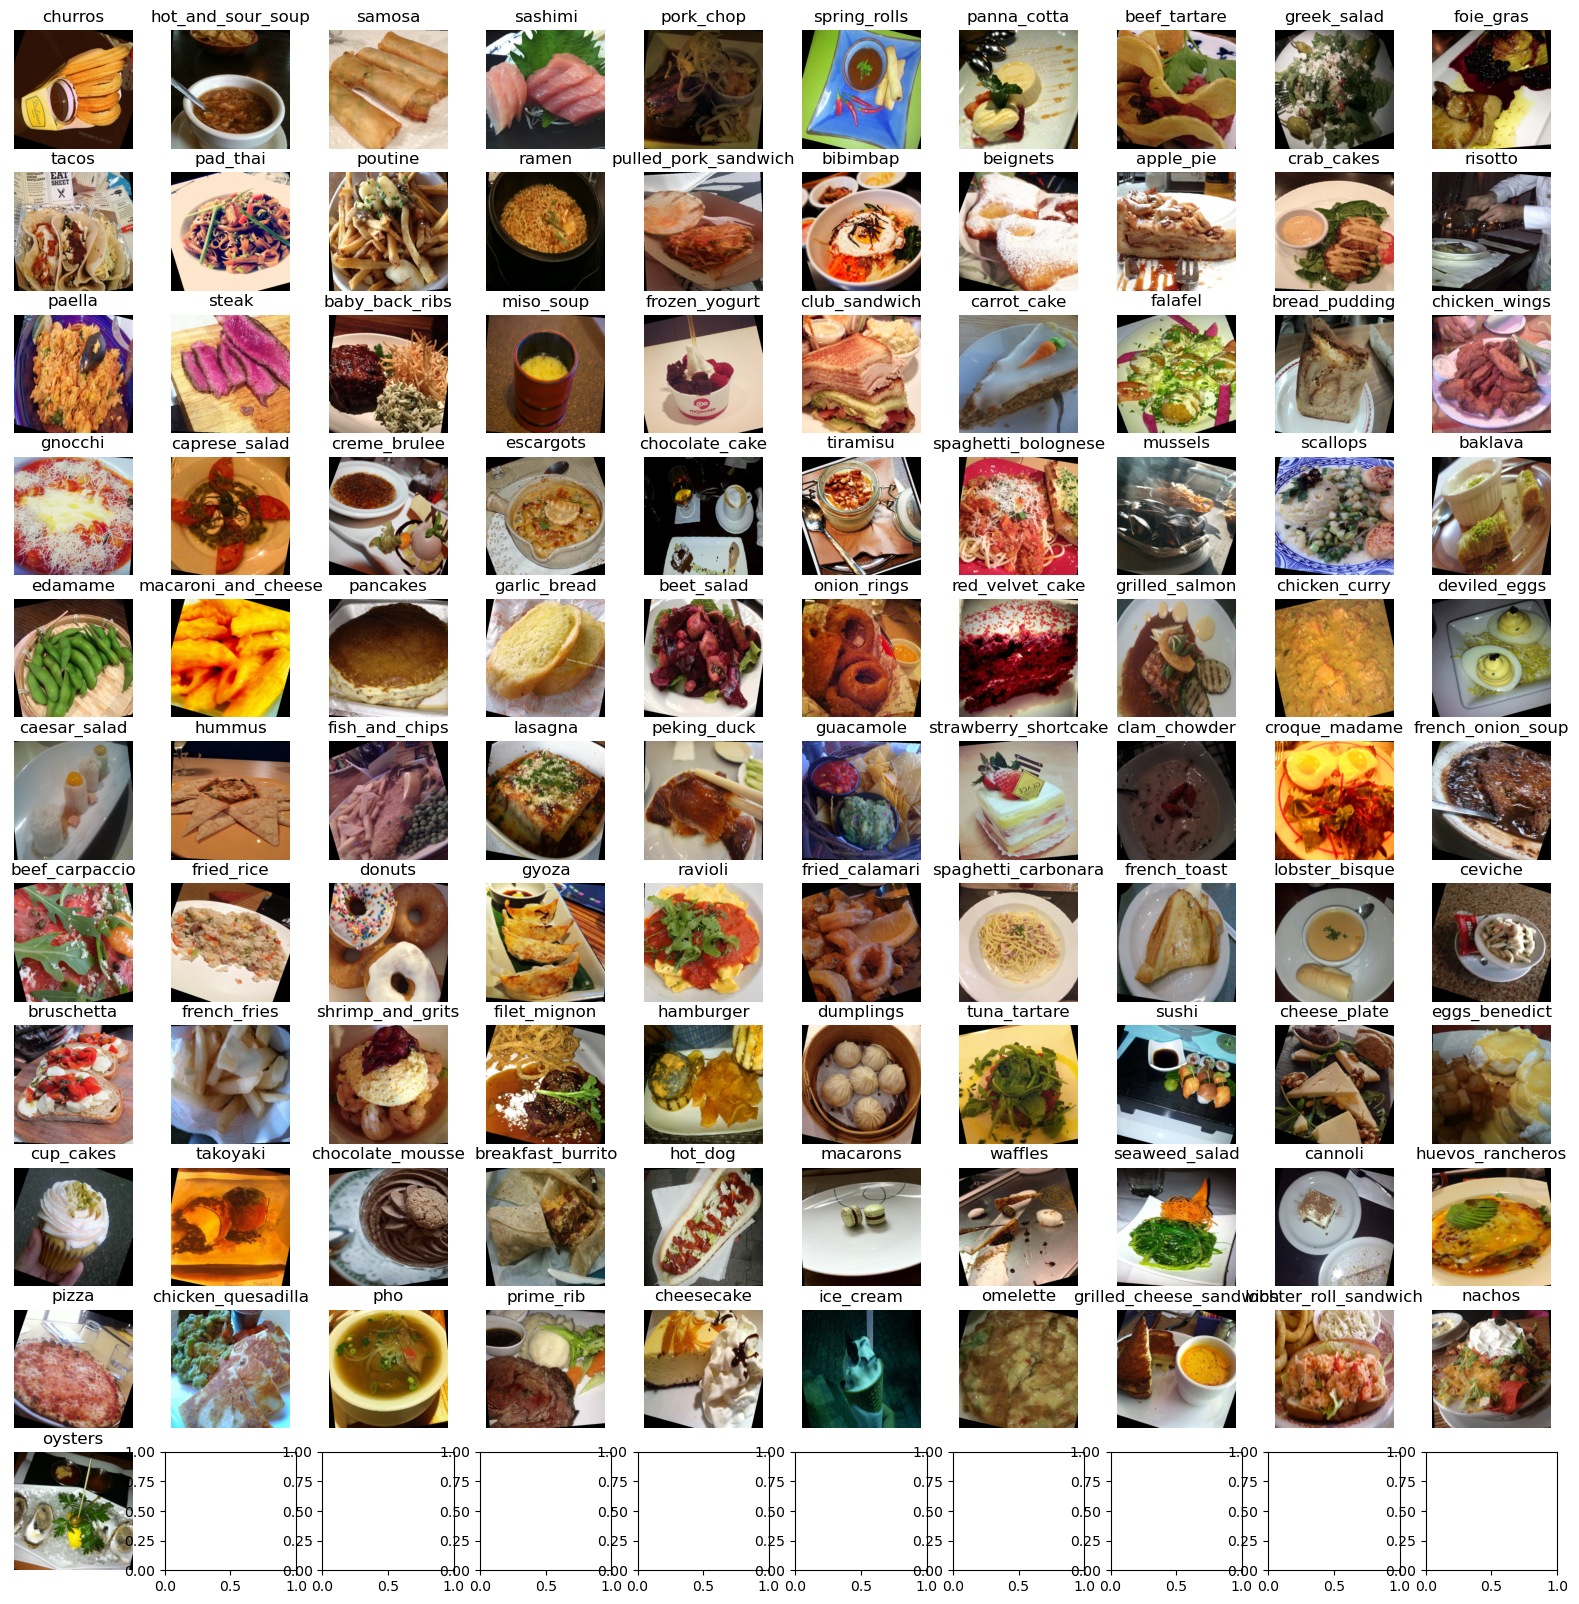

In [6]:
from torchvision import transforms
import matplotlib.pyplot as plt

train_split_json_path = data_path / "meta" / "train_split.json"
train_split_json = json.load(open(train_split_json_path))


train_preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
        transforms.ToTensor(),
    ])

def transform_image(image):
    image = train_preprocess(image)
    # we put channel last
    image = image.permute(1, 2, 0)
    return image

vizu_one_image_per_class(train_split_json, train_path, transform=transform_image)

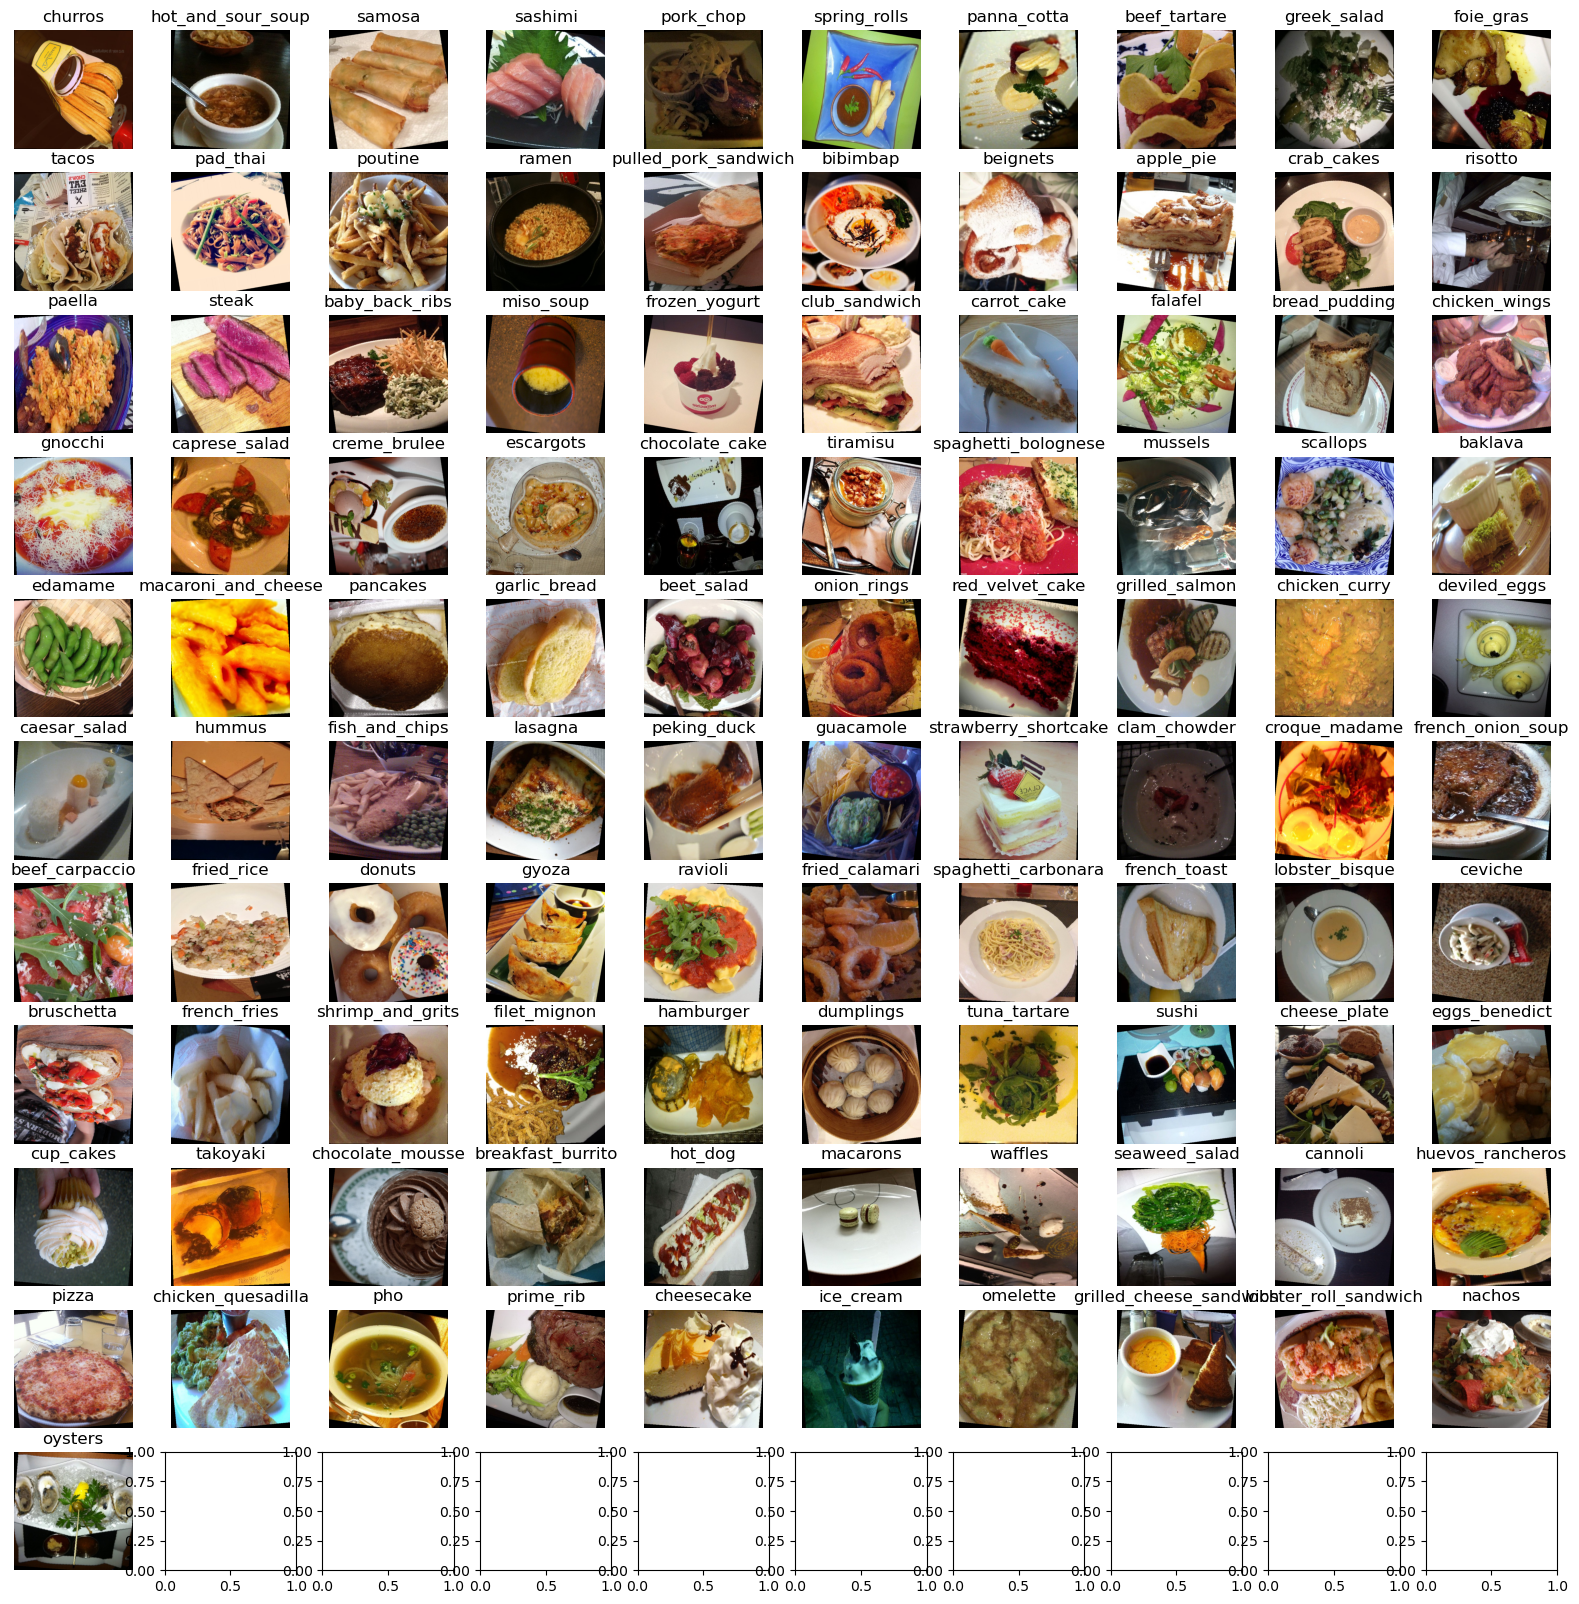

In [61]:
def transform_image(image):
    image = data_augmentation(image)
    # we put channel last
    image = image.permute(1, 2, 0)
    return image

vizu_one_image_per_class(train_split_json, train_path, transform=transform_image)

In [19]:
# model = CIFAR10Model(num_classes=101)

In [67]:
from tqdm import tqdm

train_dataset = ImageFolder(train_path, transform=preprocess)

## TODO: weird that we are using data augmentation for validation should be removed
valid_dataset = ImageFolder(valid_path, transform=preprocess)

batch_size = 32
lr = 0.001

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# Initialize the model
model = SmallConvNet(num_classes=101).to(device)
# model = CIFAR10Model(num_classes=101).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the number of epochs
n_epochs = 50

# Initialize the best validation loss
best_valid_accuracy = -float('inf')

# Train the model

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(n_epochs):
    # Initialize the train and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    train_accuracy = 0.0
    valid_accuracy = 0.0

    # Set the model to train mode
    model.train()
    
    # Loop over the training set
    pb = tqdm(desc=f"Training epoch {epoch}", total=len(train_loader))
    i = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the train loss
        train_loss += loss.item() * data.size(0)

        # compute the accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_accuracy += accuracy.item() * data.size(0)

        if i % 100 == 0:
            print(f"Train Loss: {loss.item():.4f}, Train Accuracy: {accuracy.item():.4f}"),
        i += 1
        pb.update(1)

    pb.close()

    
    # Set the model to evaluation mode
    model.eval()
    
    # Loop over the training set
    pb = tqdm(desc=f"Eval epoch {epoch}", total=len(valid_loader))

    # Turn off gradients for validation
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)

            # Update the validation loss
            valid_loss += loss.item() * data.size(0)

            # compute the accuracy
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            valid_accuracy += accuracy.item() * data.size(0)
            pb.update(1)

    pb.close()

    # Calculate the average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    train_accuracy = train_accuracy / len(train_loader.dataset)
    valid_accuracy = valid_accuracy / len(valid_loader.dataset)

    # Append the losses and accuracies

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    print(f"Epoch: {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}"),

    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_model.pth")



cuda


Training epoch 0:   0%|          | 1/2036 [00:00<33:04,  1.03it/s]

Train Loss: 4.6318, Train Accuracy: 0.0000


Training epoch 0:   5%|▍         | 101/2036 [00:23<07:37,  4.23it/s]

Train Loss: 4.6160, Train Accuracy: 0.0000


Training epoch 0:  10%|▉         | 201/2036 [00:46<07:07,  4.30it/s]

Train Loss: 4.6047, Train Accuracy: 0.0312


Training epoch 0:  15%|█▍        | 301/2036 [01:09<06:47,  4.25it/s]

Train Loss: 4.5498, Train Accuracy: 0.0000


Training epoch 0:  20%|█▉        | 401/2036 [01:32<06:23,  4.26it/s]

Train Loss: 4.5687, Train Accuracy: 0.0000


Training epoch 0:  25%|██▍       | 501/2036 [01:55<05:42,  4.48it/s]

Train Loss: 4.4732, Train Accuracy: 0.0312


Training epoch 0:  30%|██▉       | 601/2036 [02:18<05:07,  4.66it/s]

Train Loss: 4.5137, Train Accuracy: 0.0000


Training epoch 0:  34%|███▍      | 701/2036 [02:41<05:27,  4.08it/s]

Train Loss: 4.4244, Train Accuracy: 0.0000


Training epoch 0:  39%|███▉      | 801/2036 [03:05<04:53,  4.21it/s]

Train Loss: 4.3815, Train Accuracy: 0.0938


Training epoch 0:  44%|████▍     | 901/2036 [03:28<04:25,  4.28it/s]

Train Loss: 4.5530, Train Accuracy: 0.0000


Training epoch 0:  49%|████▉     | 1001/2036 [03:51<04:01,  4.29it/s]

Train Loss: 4.5202, Train Accuracy: 0.0312


Training epoch 0:  54%|█████▍    | 1101/2036 [04:14<03:38,  4.27it/s]

Train Loss: 4.2980, Train Accuracy: 0.0000


Training epoch 0:  59%|█████▉    | 1201/2036 [04:37<03:16,  4.26it/s]

Train Loss: 4.2309, Train Accuracy: 0.1562


Training epoch 0:  64%|██████▍   | 1301/2036 [05:00<02:44,  4.48it/s]

Train Loss: 4.0664, Train Accuracy: 0.1875


Training epoch 0:  69%|██████▉   | 1401/2036 [05:23<02:16,  4.66it/s]

Train Loss: 4.2499, Train Accuracy: 0.0938


Training epoch 0:  74%|███████▎  | 1501/2036 [05:47<02:01,  4.39it/s]

Train Loss: 4.3799, Train Accuracy: 0.0000


Training epoch 0:  79%|███████▊  | 1601/2036 [06:10<01:40,  4.33it/s]

Train Loss: 4.2234, Train Accuracy: 0.0625


Training epoch 0:  84%|████████▎ | 1701/2036 [06:33<01:12,  4.65it/s]

Train Loss: 4.4662, Train Accuracy: 0.0312


Training epoch 0:  88%|████████▊ | 1801/2036 [06:56<00:56,  4.16it/s]

Train Loss: 4.2100, Train Accuracy: 0.0000


Training epoch 0:  93%|█████████▎| 1901/2036 [07:19<00:31,  4.24it/s]

Train Loss: 4.1722, Train Accuracy: 0.0312


Training epoch 0:  98%|█████████▊| 2001/2036 [07:42<00:08,  4.22it/s]

Train Loss: 4.2396, Train Accuracy: 0.0312


Eval epoch 0: 100%|██████████| 332/332 [00:34<00:00,  9.71it/s]


Epoch: 1/50: Train Loss: 4.4143, Valid Loss: 4.2603, Train Accuracy: 0.0384, Valid Accuracy: 0.0624


Training epoch 1:   0%|          | 1/2036 [00:01<38:11,  1.13s/it]

Train Loss: 4.0545, Train Accuracy: 0.0625


Training epoch 1:   5%|▍         | 101/2036 [00:24<07:28,  4.32it/s]

Train Loss: 4.5880, Train Accuracy: 0.0938


Training epoch 1:  10%|▉         | 201/2036 [00:47<06:52,  4.45it/s]

Train Loss: 4.1157, Train Accuracy: 0.0625


Training epoch 1:  15%|█▍        | 301/2036 [01:10<06:17,  4.60it/s]

Train Loss: 4.4909, Train Accuracy: 0.0625


Training epoch 1:  20%|█▉        | 401/2036 [01:33<06:34,  4.14it/s]

Train Loss: 4.3903, Train Accuracy: 0.1562


Training epoch 1:  25%|██▍       | 501/2036 [01:56<06:00,  4.26it/s]

Train Loss: 3.9350, Train Accuracy: 0.0938


Training epoch 1:  30%|██▉       | 601/2036 [02:20<05:32,  4.31it/s]

Train Loss: 4.0440, Train Accuracy: 0.0938


Training epoch 1:  34%|███▍      | 701/2036 [02:42<05:13,  4.26it/s]

Train Loss: 4.1351, Train Accuracy: 0.0625


Training epoch 1:  39%|███▉      | 801/2036 [03:06<04:33,  4.52it/s]

Train Loss: 4.2532, Train Accuracy: 0.0000


Training epoch 1:  44%|████▍     | 901/2036 [03:28<04:28,  4.22it/s]

Train Loss: 4.4301, Train Accuracy: 0.0312


Training epoch 1:  49%|████▉     | 1001/2036 [03:52<04:07,  4.18it/s]

Train Loss: 3.9952, Train Accuracy: 0.1875


Training epoch 1:  54%|█████▍    | 1101/2036 [04:15<03:36,  4.32it/s]

Train Loss: 4.1496, Train Accuracy: 0.1562


Training epoch 1:  59%|█████▉    | 1201/2036 [04:38<03:20,  4.16it/s]

Train Loss: 4.2274, Train Accuracy: 0.0312


Training epoch 1:  64%|██████▍   | 1301/2036 [05:02<02:40,  4.59it/s]

Train Loss: 3.8602, Train Accuracy: 0.1250


Training epoch 1:  69%|██████▉   | 1401/2036 [05:25<02:22,  4.45it/s]

Train Loss: 4.0185, Train Accuracy: 0.0625


Training epoch 1:  74%|███████▎  | 1501/2036 [05:48<02:07,  4.21it/s]

Train Loss: 3.8781, Train Accuracy: 0.0625


Training epoch 1:  79%|███████▊  | 1601/2036 [06:11<01:42,  4.22it/s]

Train Loss: 3.8440, Train Accuracy: 0.0938


Training epoch 1:  84%|████████▎ | 1701/2036 [06:35<01:19,  4.23it/s]

Train Loss: 4.0949, Train Accuracy: 0.0938


Training epoch 1:  88%|████████▊ | 1801/2036 [06:58<00:57,  4.07it/s]

Train Loss: 3.6317, Train Accuracy: 0.1250


Training epoch 1:  93%|█████████▎| 1901/2036 [07:22<00:31,  4.32it/s]

Train Loss: 3.7809, Train Accuracy: 0.1875


Training epoch 1:  98%|█████████▊| 2001/2036 [07:45<00:08,  4.26it/s]

Train Loss: 4.0798, Train Accuracy: 0.0938


Eval epoch 1: 100%|██████████| 332/332 [00:35<00:00,  9.38it/s]


Epoch: 2/50: Train Loss: 4.1537, Valid Loss: 4.0396, Train Accuracy: 0.0789, Valid Accuracy: 0.0931


Training epoch 2:   0%|          | 1/2036 [00:01<35:00,  1.03s/it]

Train Loss: 4.3034, Train Accuracy: 0.0625


Training epoch 2:   5%|▍         | 101/2036 [00:23<06:57,  4.63it/s]

Train Loss: 4.5127, Train Accuracy: 0.0625


Training epoch 2:  10%|▉         | 201/2036 [00:46<06:37,  4.62it/s]

Train Loss: 4.2653, Train Accuracy: 0.0625


Training epoch 2:  15%|█▍        | 301/2036 [01:09<06:50,  4.23it/s]

Train Loss: 3.7365, Train Accuracy: 0.1250


Training epoch 2:  20%|█▉        | 401/2036 [01:32<06:35,  4.13it/s]

Train Loss: 4.0301, Train Accuracy: 0.1250


Training epoch 2:  25%|██▍       | 501/2036 [01:56<06:12,  4.12it/s]

Train Loss: 3.9661, Train Accuracy: 0.2812


Training epoch 2:  30%|██▉       | 601/2036 [02:19<05:33,  4.30it/s]

Train Loss: 4.1260, Train Accuracy: 0.0312


Training epoch 2:  34%|███▍      | 701/2036 [02:42<05:14,  4.25it/s]

Train Loss: 3.7126, Train Accuracy: 0.1250


Training epoch 2:  39%|███▉      | 801/2036 [03:05<04:56,  4.17it/s]

Train Loss: 4.0830, Train Accuracy: 0.0312


Training epoch 2:  44%|████▍     | 901/2036 [03:29<04:25,  4.27it/s]

Train Loss: 4.3105, Train Accuracy: 0.0312


Training epoch 2:  49%|████▉     | 1001/2036 [03:52<04:07,  4.18it/s]

Train Loss: 4.0097, Train Accuracy: 0.0938


Training epoch 2:  54%|█████▍    | 1101/2036 [04:15<03:38,  4.27it/s]

Train Loss: 3.8001, Train Accuracy: 0.0938


Training epoch 2:  59%|█████▉    | 1201/2036 [04:39<03:18,  4.20it/s]

Train Loss: 3.7089, Train Accuracy: 0.1250


Training epoch 2:  64%|██████▍   | 1301/2036 [05:02<02:55,  4.19it/s]

Train Loss: 4.0320, Train Accuracy: 0.0938


Training epoch 2:  69%|██████▉   | 1401/2036 [05:25<02:16,  4.64it/s]

Train Loss: 3.7891, Train Accuracy: 0.1250


Training epoch 2:  74%|███████▎  | 1501/2036 [05:48<01:58,  4.50it/s]

Train Loss: 3.9004, Train Accuracy: 0.1562


Training epoch 2:  79%|███████▊  | 1601/2036 [06:12<01:43,  4.20it/s]

Train Loss: 3.8435, Train Accuracy: 0.1562


Training epoch 2:  84%|████████▎ | 1701/2036 [06:35<01:19,  4.22it/s]

Train Loss: 4.0464, Train Accuracy: 0.0625


Training epoch 2:  88%|████████▊ | 1801/2036 [06:58<00:53,  4.41it/s]

Train Loss: 4.0991, Train Accuracy: 0.0000


Training epoch 2:  93%|█████████▎| 1901/2036 [07:21<00:30,  4.42it/s]

Train Loss: 4.0229, Train Accuracy: 0.0625


Training epoch 2:  98%|█████████▊| 2001/2036 [07:44<00:07,  4.57it/s]

Train Loss: 3.8334, Train Accuracy: 0.1875


Eval epoch 2: 100%|██████████| 332/332 [00:30<00:00, 10.74it/s]


Epoch: 3/50: Train Loss: 3.9601, Valid Loss: 3.8695, Train Accuracy: 0.1122, Valid Accuracy: 0.1321


Training epoch 3:   0%|          | 1/2036 [00:00<31:24,  1.08it/s]

Train Loss: 3.9857, Train Accuracy: 0.1562


Training epoch 3:   5%|▍         | 101/2036 [00:23<07:09,  4.51it/s]

Train Loss: 3.7852, Train Accuracy: 0.0938


Training epoch 3:  10%|▉         | 201/2036 [00:46<07:16,  4.20it/s]

Train Loss: 3.9106, Train Accuracy: 0.1562


Training epoch 3:  15%|█▍        | 301/2036 [01:08<06:52,  4.21it/s]

Train Loss: 3.8743, Train Accuracy: 0.1250


Training epoch 3:  20%|█▉        | 401/2036 [01:31<05:56,  4.59it/s]

Train Loss: 3.8123, Train Accuracy: 0.1562


Training epoch 3:  25%|██▍       | 501/2036 [01:55<05:46,  4.43it/s]

Train Loss: 3.9461, Train Accuracy: 0.0625


Training epoch 3:  30%|██▉       | 601/2036 [02:19<05:45,  4.15it/s]

Train Loss: 4.1297, Train Accuracy: 0.1562


Training epoch 3:  34%|███▍      | 701/2036 [02:42<05:22,  4.14it/s]

Train Loss: 3.6594, Train Accuracy: 0.2188


Training epoch 3:  39%|███▉      | 801/2036 [03:05<04:53,  4.21it/s]

Train Loss: 3.5584, Train Accuracy: 0.1875


Training epoch 3:  44%|████▍     | 901/2036 [03:28<04:36,  4.10it/s]

Train Loss: 3.6819, Train Accuracy: 0.1562


Training epoch 3:  49%|████▉     | 1001/2036 [03:52<04:08,  4.17it/s]

Train Loss: 3.6788, Train Accuracy: 0.1250


Training epoch 3:  54%|█████▍    | 1101/2036 [04:16<03:44,  4.16it/s]

Train Loss: 3.1031, Train Accuracy: 0.2812


Training epoch 3:  59%|█████▉    | 1201/2036 [04:39<03:23,  4.10it/s]

Train Loss: 3.4636, Train Accuracy: 0.2500


Training epoch 3:  64%|██████▍   | 1301/2036 [05:01<02:56,  4.16it/s]

Train Loss: 3.8677, Train Accuracy: 0.0625


Training epoch 3:  69%|██████▉   | 1401/2036 [05:25<02:35,  4.08it/s]

Train Loss: 3.7815, Train Accuracy: 0.1250


Training epoch 3:  74%|███████▎  | 1501/2036 [05:49<01:57,  4.54it/s]

Train Loss: 3.6416, Train Accuracy: 0.0938


Training epoch 3:  79%|███████▊  | 1601/2036 [06:13<01:43,  4.19it/s]

Train Loss: 3.4462, Train Accuracy: 0.2188


Training epoch 3:  84%|████████▎ | 1701/2036 [06:36<01:12,  4.60it/s]

Train Loss: 3.2141, Train Accuracy: 0.3125


Training epoch 3:  88%|████████▊ | 1801/2036 [07:00<00:57,  4.12it/s]

Train Loss: 3.8503, Train Accuracy: 0.1875


Training epoch 3:  93%|█████████▎| 1901/2036 [07:23<00:32,  4.19it/s]

Train Loss: 3.8840, Train Accuracy: 0.1250


Training epoch 3:  98%|█████████▊| 2001/2036 [07:46<00:08,  4.20it/s]

Train Loss: 3.2751, Train Accuracy: 0.2812


Eval epoch 3: 100%|██████████| 332/332 [00:35<00:00,  9.42it/s]


Epoch: 4/50: Train Loss: 3.7766, Valid Loss: 3.6850, Train Accuracy: 0.1430, Valid Accuracy: 0.1542


Training epoch 4:   0%|          | 1/2036 [00:01<36:29,  1.08s/it]

Train Loss: 3.7895, Train Accuracy: 0.1562


Training epoch 4:   5%|▍         | 101/2036 [00:24<07:28,  4.31it/s]

Train Loss: 3.9613, Train Accuracy: 0.0625


Training epoch 4:  10%|▉         | 201/2036 [00:47<07:07,  4.29it/s]

Train Loss: 3.3158, Train Accuracy: 0.2500


Training epoch 4:  15%|█▍        | 301/2036 [01:10<06:44,  4.29it/s]

Train Loss: 3.6315, Train Accuracy: 0.1250


Training epoch 4:  20%|█▉        | 401/2036 [01:33<06:20,  4.30it/s]

Train Loss: 3.2782, Train Accuracy: 0.2500


Training epoch 4:  25%|██▍       | 501/2036 [01:57<06:09,  4.15it/s]

Train Loss: 3.9390, Train Accuracy: 0.2812


Training epoch 4:  30%|██▉       | 601/2036 [02:21<05:24,  4.42it/s]

Train Loss: 3.5218, Train Accuracy: 0.1250


Training epoch 4:  34%|███▍      | 701/2036 [02:44<05:24,  4.12it/s]

Train Loss: 3.8494, Train Accuracy: 0.1875


Training epoch 4:  39%|███▉      | 801/2036 [03:07<04:52,  4.22it/s]

Train Loss: 3.3402, Train Accuracy: 0.1875


Training epoch 4:  44%|████▍     | 901/2036 [03:31<04:19,  4.38it/s]

Train Loss: 3.5977, Train Accuracy: 0.1562


Training epoch 4:  49%|████▉     | 1001/2036 [03:54<04:04,  4.23it/s]

Train Loss: 3.7835, Train Accuracy: 0.1250


Training epoch 4:  54%|█████▍    | 1101/2036 [04:17<03:43,  4.19it/s]

Train Loss: 3.5859, Train Accuracy: 0.1250


Training epoch 4:  59%|█████▉    | 1201/2036 [04:41<03:22,  4.13it/s]

Train Loss: 3.6382, Train Accuracy: 0.1562


Training epoch 4:  64%|██████▍   | 1301/2036 [05:03<02:54,  4.21it/s]

Train Loss: 3.2467, Train Accuracy: 0.3438


Training epoch 4:  69%|██████▉   | 1401/2036 [05:27<02:32,  4.17it/s]

Train Loss: 3.5833, Train Accuracy: 0.0938


Training epoch 4:  74%|███████▎  | 1501/2036 [05:50<02:07,  4.20it/s]

Train Loss: 3.5961, Train Accuracy: 0.1562


Training epoch 4:  79%|███████▊  | 1601/2036 [06:14<01:43,  4.22it/s]

Train Loss: 3.6888, Train Accuracy: 0.0938


Training epoch 4:  84%|████████▎ | 1701/2036 [06:36<01:13,  4.59it/s]

Train Loss: 3.7255, Train Accuracy: 0.2500


Training epoch 4:  88%|████████▊ | 1801/2036 [06:59<00:51,  4.58it/s]

Train Loss: 3.7533, Train Accuracy: 0.0938


Training epoch 4:  93%|█████████▎| 1901/2036 [07:23<00:32,  4.12it/s]

Train Loss: 3.5730, Train Accuracy: 0.3438


Training epoch 4:  98%|█████████▊| 2001/2036 [07:46<00:08,  4.20it/s]

Train Loss: 3.7750, Train Accuracy: 0.0938


Eval epoch 4: 100%|██████████| 332/332 [00:37<00:00,  8.93it/s]


Epoch: 5/50: Train Loss: 3.6184, Valid Loss: 3.5600, Train Accuracy: 0.1730, Valid Accuracy: 0.1884


Training epoch 5:   0%|          | 1/2036 [00:01<36:05,  1.06s/it]

Train Loss: 3.7114, Train Accuracy: 0.1875


Training epoch 5:   5%|▍         | 101/2036 [00:23<07:02,  4.58it/s]

Train Loss: 3.4801, Train Accuracy: 0.2500


Training epoch 5:  10%|▉         | 201/2036 [00:46<06:39,  4.59it/s]

Train Loss: 3.7240, Train Accuracy: 0.0938


Training epoch 5:  15%|█▍        | 301/2036 [01:09<06:17,  4.59it/s]

Train Loss: 3.7528, Train Accuracy: 0.2500


Training epoch 5:  20%|█▉        | 401/2036 [01:32<06:22,  4.28it/s]

Train Loss: 3.8123, Train Accuracy: 0.1250


Training epoch 5:  25%|██▍       | 501/2036 [01:56<06:06,  4.19it/s]

Train Loss: 4.0725, Train Accuracy: 0.1875


Training epoch 5:  30%|██▉       | 601/2036 [02:19<05:28,  4.37it/s]

Train Loss: 3.7749, Train Accuracy: 0.1250


Training epoch 5:  34%|███▍      | 701/2036 [02:42<04:51,  4.58it/s]

Train Loss: 3.6195, Train Accuracy: 0.1562


Training epoch 5:  39%|███▉      | 801/2036 [03:06<05:02,  4.08it/s]

Train Loss: 3.3280, Train Accuracy: 0.1250


Training epoch 5:  44%|████▍     | 901/2036 [03:29<04:27,  4.25it/s]

Train Loss: 3.2485, Train Accuracy: 0.1875


Training epoch 5:  49%|████▉     | 1001/2036 [03:53<03:51,  4.47it/s]

Train Loss: 3.3694, Train Accuracy: 0.1562


Training epoch 5:  54%|█████▍    | 1101/2036 [04:16<03:40,  4.24it/s]

Train Loss: 3.4662, Train Accuracy: 0.2188


Training epoch 5:  59%|█████▉    | 1201/2036 [04:39<03:08,  4.43it/s]

Train Loss: 3.6275, Train Accuracy: 0.1562


Training epoch 5:  64%|██████▍   | 1301/2036 [05:02<02:40,  4.57it/s]

Train Loss: 3.7407, Train Accuracy: 0.1562


Training epoch 5:  69%|██████▉   | 1401/2036 [05:26<02:34,  4.12it/s]

Train Loss: 3.8750, Train Accuracy: 0.1562


Training epoch 5:  74%|███████▎  | 1501/2036 [05:49<01:59,  4.48it/s]

Train Loss: 3.1825, Train Accuracy: 0.3125


Training epoch 5:  79%|███████▊  | 1601/2036 [06:12<01:33,  4.63it/s]

Train Loss: 3.4541, Train Accuracy: 0.2500


Training epoch 5:  84%|████████▎ | 1701/2036 [06:35<01:14,  4.52it/s]

Train Loss: 4.0027, Train Accuracy: 0.1250


Training epoch 5:  88%|████████▊ | 1801/2036 [06:59<00:57,  4.07it/s]

Train Loss: 3.3790, Train Accuracy: 0.1875


Training epoch 5:  93%|█████████▎| 1901/2036 [07:23<00:30,  4.48it/s]

Train Loss: 3.7959, Train Accuracy: 0.1250


Training epoch 5:  98%|█████████▊| 2001/2036 [07:46<00:07,  4.61it/s]

Train Loss: 3.3969, Train Accuracy: 0.1562


Eval epoch 5: 100%|██████████| 332/332 [00:35<00:00,  9.37it/s]


Epoch: 6/50: Train Loss: 3.4978, Valid Loss: 3.4590, Train Accuracy: 0.1960, Valid Accuracy: 0.2053


Training epoch 6:   0%|          | 1/2036 [00:01<34:22,  1.01s/it]

Train Loss: 2.9870, Train Accuracy: 0.3438


Training epoch 6:   5%|▍         | 101/2036 [00:24<07:43,  4.18it/s]

Train Loss: 2.8818, Train Accuracy: 0.3125


Training epoch 6:  10%|▉         | 201/2036 [00:48<07:20,  4.17it/s]

Train Loss: 3.0650, Train Accuracy: 0.1875


Training epoch 6:  15%|█▍        | 301/2036 [01:12<06:55,  4.17it/s]

Train Loss: 3.5100, Train Accuracy: 0.2500


Training epoch 6:  20%|█▉        | 401/2036 [01:35<06:29,  4.20it/s]

Train Loss: 3.4471, Train Accuracy: 0.1250


Training epoch 6:  25%|██▍       | 501/2036 [01:59<06:06,  4.18it/s]

Train Loss: 3.0023, Train Accuracy: 0.1562


Training epoch 6:  30%|██▉       | 601/2036 [02:22<05:21,  4.46it/s]

Train Loss: 3.6231, Train Accuracy: 0.1562


Training epoch 6:  34%|███▍      | 701/2036 [02:45<04:49,  4.62it/s]

Train Loss: 3.6478, Train Accuracy: 0.0938


Training epoch 6:  39%|███▉      | 801/2036 [03:08<04:27,  4.61it/s]

Train Loss: 3.2036, Train Accuracy: 0.2500


Training epoch 6:  44%|████▍     | 901/2036 [03:31<04:27,  4.24it/s]

Train Loss: 3.7553, Train Accuracy: 0.1875


Training epoch 6:  49%|████▉     | 1001/2036 [03:55<03:56,  4.38it/s]

Train Loss: 3.7420, Train Accuracy: 0.2500


Training epoch 6:  54%|█████▍    | 1101/2036 [04:19<03:30,  4.44it/s]

Train Loss: 3.2498, Train Accuracy: 0.2812


Training epoch 6:  59%|█████▉    | 1201/2036 [04:42<03:24,  4.08it/s]

Train Loss: 3.5079, Train Accuracy: 0.2188


Training epoch 6:  64%|██████▍   | 1301/2036 [05:06<02:41,  4.54it/s]

Train Loss: 3.8361, Train Accuracy: 0.1250


Training epoch 6:  69%|██████▉   | 1401/2036 [05:29<02:31,  4.20it/s]

Train Loss: 3.2871, Train Accuracy: 0.0625


Training epoch 6:  74%|███████▎  | 1501/2036 [05:52<02:05,  4.26it/s]

Train Loss: 4.0303, Train Accuracy: 0.1562


Training epoch 6:  79%|███████▊  | 1601/2036 [06:16<01:44,  4.14it/s]

Train Loss: 2.8294, Train Accuracy: 0.2812


Training epoch 6:  84%|████████▎ | 1701/2036 [06:39<01:22,  4.04it/s]

Train Loss: 3.6255, Train Accuracy: 0.1875


Training epoch 6:  88%|████████▊ | 1801/2036 [07:04<00:52,  4.49it/s]

Train Loss: 3.8021, Train Accuracy: 0.0938


Training epoch 6:  93%|█████████▎| 1901/2036 [07:27<00:33,  4.06it/s]

Train Loss: 3.1327, Train Accuracy: 0.3125


Training epoch 6:  98%|█████████▊| 2001/2036 [07:51<00:07,  4.58it/s]

Train Loss: 3.7254, Train Accuracy: 0.1250


Eval epoch 6: 100%|██████████| 332/332 [00:35<00:00,  9.37it/s]


Epoch: 7/50: Train Loss: 3.3966, Valid Loss: 3.3617, Train Accuracy: 0.2163, Valid Accuracy: 0.2260


Training epoch 7:   0%|          | 1/2036 [00:00<33:27,  1.01it/s]

Train Loss: 3.1662, Train Accuracy: 0.1875


Training epoch 7:   5%|▍         | 101/2036 [00:24<07:39,  4.21it/s]

Train Loss: 2.8663, Train Accuracy: 0.2812


Training epoch 7:  10%|▉         | 201/2036 [00:47<07:20,  4.16it/s]

Train Loss: 3.5059, Train Accuracy: 0.2188


Training epoch 7:  15%|█▍        | 301/2036 [01:11<06:53,  4.19it/s]

Train Loss: 3.1976, Train Accuracy: 0.2500


Training epoch 7:  20%|█▉        | 401/2036 [01:35<06:23,  4.27it/s]

Train Loss: 3.7908, Train Accuracy: 0.2188


Training epoch 7:  25%|██▍       | 501/2036 [01:58<06:06,  4.19it/s]

Train Loss: 3.3206, Train Accuracy: 0.1875


Training epoch 7:  30%|██▉       | 601/2036 [02:21<05:10,  4.62it/s]

Train Loss: 3.1905, Train Accuracy: 0.2500


Training epoch 7:  34%|███▍      | 701/2036 [02:44<04:49,  4.62it/s]

Train Loss: 3.5691, Train Accuracy: 0.1875


Training epoch 7:  39%|███▉      | 801/2036 [03:08<04:52,  4.23it/s]

Train Loss: 3.2808, Train Accuracy: 0.1875


Training epoch 7:  44%|████▍     | 901/2036 [03:30<04:03,  4.66it/s]

Train Loss: 3.2010, Train Accuracy: 0.1562


Training epoch 7:  49%|████▉     | 1001/2036 [03:52<03:42,  4.66it/s]

Train Loss: 3.2782, Train Accuracy: 0.1562


Training epoch 7:  54%|█████▍    | 1101/2036 [04:15<03:29,  4.47it/s]

Train Loss: 3.3468, Train Accuracy: 0.1875


Training epoch 7:  59%|█████▉    | 1201/2036 [04:39<03:14,  4.28it/s]

Train Loss: 3.2460, Train Accuracy: 0.2812


Training epoch 7:  64%|██████▍   | 1301/2036 [05:02<02:57,  4.15it/s]

Train Loss: 3.0859, Train Accuracy: 0.2500


Training epoch 7:  69%|██████▉   | 1401/2036 [05:26<02:31,  4.21it/s]

Train Loss: 3.4355, Train Accuracy: 0.1875


Training epoch 7:  74%|███████▎  | 1501/2036 [05:49<02:06,  4.23it/s]

Train Loss: 3.3761, Train Accuracy: 0.1562


Training epoch 7:  79%|███████▊  | 1601/2036 [06:12<01:39,  4.37it/s]

Train Loss: 3.0665, Train Accuracy: 0.2812


Training epoch 7:  84%|████████▎ | 1701/2036 [06:36<01:19,  4.20it/s]

Train Loss: 3.9326, Train Accuracy: 0.1875


Training epoch 7:  88%|████████▊ | 1801/2036 [06:59<00:56,  4.15it/s]

Train Loss: 3.2340, Train Accuracy: 0.3125


Training epoch 7:  93%|█████████▎| 1901/2036 [07:22<00:30,  4.47it/s]

Train Loss: 3.4849, Train Accuracy: 0.1562


Training epoch 7:  98%|█████████▊| 2001/2036 [07:46<00:07,  4.58it/s]

Train Loss: 3.0220, Train Accuracy: 0.2500


Eval epoch 7: 100%|██████████| 332/332 [00:36<00:00,  8.99it/s]


Epoch: 8/50: Train Loss: 3.2987, Valid Loss: 3.3019, Train Accuracy: 0.2331, Valid Accuracy: 0.2378


Training epoch 8:   0%|          | 1/2036 [00:01<38:05,  1.12s/it]

Train Loss: 2.8169, Train Accuracy: 0.2812


Training epoch 8:   5%|▍         | 101/2036 [00:23<07:38,  4.22it/s]

Train Loss: 3.0892, Train Accuracy: 0.3125


Training epoch 8:  10%|▉         | 201/2036 [00:47<07:27,  4.10it/s]

Train Loss: 3.3980, Train Accuracy: 0.3125


Training epoch 8:  15%|█▍        | 301/2036 [01:10<07:05,  4.08it/s]

Train Loss: 3.1675, Train Accuracy: 0.2188


Training epoch 8:  20%|█▉        | 401/2036 [01:34<05:58,  4.56it/s]

Train Loss: 3.2157, Train Accuracy: 0.2500


Training epoch 8:  25%|██▍       | 501/2036 [01:57<06:06,  4.19it/s]

Train Loss: 3.0382, Train Accuracy: 0.3125


Training epoch 8:  30%|██▉       | 601/2036 [02:21<05:47,  4.12it/s]

Train Loss: 3.3410, Train Accuracy: 0.2500


Training epoch 8:  34%|███▍      | 701/2036 [02:45<05:23,  4.12it/s]

Train Loss: 3.1683, Train Accuracy: 0.2500


Training epoch 8:  39%|███▉      | 801/2036 [03:09<05:02,  4.08it/s]

Train Loss: 2.9433, Train Accuracy: 0.3438


Training epoch 8:  44%|████▍     | 901/2036 [03:33<04:35,  4.12it/s]

Train Loss: 3.1485, Train Accuracy: 0.2188


Training epoch 8:  49%|████▉     | 1001/2036 [03:56<04:04,  4.23it/s]

Train Loss: 3.1871, Train Accuracy: 0.2500


Training epoch 8:  54%|█████▍    | 1101/2036 [04:19<03:39,  4.26it/s]

Train Loss: 3.2996, Train Accuracy: 0.2500


Training epoch 8:  59%|█████▉    | 1201/2036 [04:42<03:02,  4.57it/s]

Train Loss: 2.9451, Train Accuracy: 0.2500


Training epoch 8:  64%|██████▍   | 1301/2036 [05:06<02:54,  4.21it/s]

Train Loss: 3.3363, Train Accuracy: 0.1875


Training epoch 8:  69%|██████▉   | 1401/2036 [05:29<02:32,  4.15it/s]

Train Loss: 2.8601, Train Accuracy: 0.3438


Training epoch 8:  74%|███████▎  | 1501/2036 [05:52<01:58,  4.50it/s]

Train Loss: 3.4401, Train Accuracy: 0.2188


Training epoch 8:  79%|███████▊  | 1601/2036 [06:16<01:42,  4.24it/s]

Train Loss: 3.2658, Train Accuracy: 0.2500


Training epoch 8:  84%|████████▎ | 1701/2036 [06:39<01:19,  4.19it/s]

Train Loss: 3.4039, Train Accuracy: 0.4062


Training epoch 8:  88%|████████▊ | 1801/2036 [07:03<00:56,  4.13it/s]

Train Loss: 3.1219, Train Accuracy: 0.1562


Training epoch 8:  93%|█████████▎| 1901/2036 [07:26<00:29,  4.64it/s]

Train Loss: 2.8520, Train Accuracy: 0.3750


Training epoch 8:  98%|█████████▊| 2001/2036 [07:49<00:08,  4.37it/s]

Train Loss: 3.7410, Train Accuracy: 0.2500


Eval epoch 8: 100%|██████████| 332/332 [00:35<00:00,  9.36it/s]


Epoch: 9/50: Train Loss: 3.2187, Valid Loss: 3.2416, Train Accuracy: 0.2510, Valid Accuracy: 0.2513


Training epoch 9:   0%|          | 1/2036 [00:00<30:28,  1.11it/s]

Train Loss: 3.4410, Train Accuracy: 0.2500


Training epoch 9:   5%|▍         | 101/2036 [00:23<07:00,  4.60it/s]

Train Loss: 3.4790, Train Accuracy: 0.2500


Training epoch 9:  10%|▉         | 201/2036 [00:46<07:14,  4.22it/s]

Train Loss: 3.1606, Train Accuracy: 0.2812


Training epoch 9:  15%|█▍        | 301/2036 [01:10<07:02,  4.11it/s]

Train Loss: 2.8369, Train Accuracy: 0.2188


Training epoch 9:  20%|█▉        | 401/2036 [01:34<06:39,  4.09it/s]

Train Loss: 3.2010, Train Accuracy: 0.1875


Training epoch 9:  25%|██▍       | 501/2036 [01:57<05:50,  4.38it/s]

Train Loss: 2.6757, Train Accuracy: 0.3125


Training epoch 9:  30%|██▉       | 601/2036 [02:21<05:39,  4.23it/s]

Train Loss: 2.9075, Train Accuracy: 0.3438


Training epoch 9:  34%|███▍      | 701/2036 [02:44<05:13,  4.26it/s]

Train Loss: 2.8942, Train Accuracy: 0.2500


Training epoch 9:  39%|███▉      | 801/2036 [03:07<04:27,  4.62it/s]

Train Loss: 3.3064, Train Accuracy: 0.1875


Training epoch 9:  44%|████▍     | 901/2036 [03:31<04:31,  4.18it/s]

Train Loss: 3.7677, Train Accuracy: 0.2812


Training epoch 9:  49%|████▉     | 1001/2036 [03:54<03:56,  4.37it/s]

Train Loss: 3.4787, Train Accuracy: 0.1562


Training epoch 9:  54%|█████▍    | 1101/2036 [04:17<03:43,  4.18it/s]

Train Loss: 3.4541, Train Accuracy: 0.3125


Training epoch 9:  59%|█████▉    | 1201/2036 [04:41<03:19,  4.19it/s]

Train Loss: 2.9505, Train Accuracy: 0.2188


Training epoch 9:  64%|██████▍   | 1301/2036 [05:04<02:43,  4.49it/s]

Train Loss: 3.1186, Train Accuracy: 0.1562


Training epoch 9:  69%|██████▉   | 1401/2036 [05:26<02:26,  4.33it/s]

Train Loss: 3.0778, Train Accuracy: 0.2812


Training epoch 9:  74%|███████▎  | 1501/2036 [05:50<02:08,  4.15it/s]

Train Loss: 3.2117, Train Accuracy: 0.1875


Training epoch 9:  79%|███████▊  | 1601/2036 [06:13<01:42,  4.24it/s]

Train Loss: 3.1534, Train Accuracy: 0.2188


Training epoch 9:  84%|████████▎ | 1701/2036 [06:36<01:14,  4.52it/s]

Train Loss: 3.3703, Train Accuracy: 0.2500


Training epoch 9:  88%|████████▊ | 1801/2036 [06:59<00:56,  4.18it/s]

Train Loss: 3.1592, Train Accuracy: 0.3125


Training epoch 9:  93%|█████████▎| 1901/2036 [07:22<00:32,  4.20it/s]

Train Loss: 3.2650, Train Accuracy: 0.2188


Training epoch 9:  98%|█████████▊| 2001/2036 [07:46<00:08,  4.12it/s]

Train Loss: 3.0919, Train Accuracy: 0.2500


Eval epoch 9: 100%|██████████| 332/332 [00:36<00:00,  9.03it/s]


Epoch: 10/50: Train Loss: 3.1448, Valid Loss: 3.1739, Train Accuracy: 0.2654, Valid Accuracy: 0.2708


Training epoch 10:   0%|          | 1/2036 [00:01<36:42,  1.08s/it]

Train Loss: 2.9245, Train Accuracy: 0.3125


Training epoch 10:   5%|▍         | 101/2036 [00:24<07:40,  4.20it/s]

Train Loss: 4.1268, Train Accuracy: 0.1250


Training epoch 10:  10%|▉         | 201/2036 [00:48<07:20,  4.16it/s]

Train Loss: 3.4633, Train Accuracy: 0.2500


Training epoch 10:  15%|█▍        | 301/2036 [01:11<06:59,  4.13it/s]

Train Loss: 2.9681, Train Accuracy: 0.3438


Training epoch 10:  20%|█▉        | 401/2036 [01:34<06:28,  4.21it/s]

Train Loss: 3.1175, Train Accuracy: 0.2812


Training epoch 10:  25%|██▍       | 501/2036 [01:57<06:11,  4.13it/s]

Train Loss: 3.1580, Train Accuracy: 0.2500


Training epoch 10:  30%|██▉       | 601/2036 [02:22<05:51,  4.08it/s]

Train Loss: 3.0147, Train Accuracy: 0.2500


Training epoch 10:  34%|███▍      | 701/2036 [02:45<05:27,  4.08it/s]

Train Loss: 3.1236, Train Accuracy: 0.2500


Training epoch 10:  39%|███▉      | 801/2036 [03:09<04:45,  4.32it/s]

Train Loss: 2.8556, Train Accuracy: 0.3438


Training epoch 10:  44%|████▍     | 901/2036 [03:34<04:36,  4.10it/s]

Train Loss: 3.1438, Train Accuracy: 0.2812


Training epoch 10:  49%|████▉     | 1001/2036 [03:58<04:18,  4.01it/s]

Train Loss: 3.4427, Train Accuracy: 0.1562


Training epoch 10:  54%|█████▍    | 1101/2036 [04:21<03:39,  4.26it/s]

Train Loss: 3.0830, Train Accuracy: 0.2188


Training epoch 10:  59%|█████▉    | 1201/2036 [04:44<03:15,  4.27it/s]

Train Loss: 3.0336, Train Accuracy: 0.4062


Training epoch 10:  64%|██████▍   | 1301/2036 [05:07<02:48,  4.37it/s]

Train Loss: 3.6256, Train Accuracy: 0.1875


Training epoch 10:  69%|██████▉   | 1401/2036 [05:30<02:29,  4.24it/s]

Train Loss: 3.6444, Train Accuracy: 0.3125


Training epoch 10:  74%|███████▎  | 1501/2036 [05:53<02:07,  4.20it/s]

Train Loss: 3.7223, Train Accuracy: 0.2188


Training epoch 10:  79%|███████▊  | 1601/2036 [06:17<01:45,  4.12it/s]

Train Loss: 3.5791, Train Accuracy: 0.1875


Training epoch 10:  84%|████████▎ | 1701/2036 [06:41<01:20,  4.15it/s]

Train Loss: 3.3925, Train Accuracy: 0.2812


Training epoch 10:  88%|████████▊ | 1801/2036 [07:04<00:56,  4.16it/s]

Train Loss: 2.8124, Train Accuracy: 0.3125


Training epoch 10:  93%|█████████▎| 1901/2036 [07:27<00:31,  4.34it/s]

Train Loss: 3.0253, Train Accuracy: 0.2812


Training epoch 10:  98%|█████████▊| 2001/2036 [07:50<00:08,  4.27it/s]

Train Loss: 2.9109, Train Accuracy: 0.3750


Eval epoch 10: 100%|██████████| 332/332 [00:34<00:00,  9.60it/s]


Epoch: 11/50: Train Loss: 3.0711, Valid Loss: 3.0799, Train Accuracy: 0.2808, Valid Accuracy: 0.2882


Training epoch 11:   0%|          | 1/2036 [00:00<31:30,  1.08it/s]

Train Loss: 2.7492, Train Accuracy: 0.4375


Training epoch 11:   5%|▍         | 101/2036 [00:24<07:36,  4.24it/s]

Train Loss: 2.8050, Train Accuracy: 0.2812


Training epoch 11:  10%|▉         | 201/2036 [00:47<07:08,  4.28it/s]

Train Loss: 2.6130, Train Accuracy: 0.3438


Training epoch 11:  15%|█▍        | 301/2036 [01:10<06:48,  4.24it/s]

Train Loss: 2.8434, Train Accuracy: 0.4375


Training epoch 11:  20%|█▉        | 401/2036 [01:34<06:30,  4.19it/s]

Train Loss: 2.2544, Train Accuracy: 0.4062


Training epoch 11:  25%|██▍       | 501/2036 [01:58<06:10,  4.14it/s]

Train Loss: 2.8202, Train Accuracy: 0.4062


Training epoch 11:  30%|██▉       | 601/2036 [02:21<05:15,  4.54it/s]

Train Loss: 2.6530, Train Accuracy: 0.4062


Training epoch 11:  34%|███▍      | 701/2036 [02:45<05:20,  4.16it/s]

Train Loss: 3.5864, Train Accuracy: 0.1562


Training epoch 11:  39%|███▉      | 801/2036 [03:09<04:58,  4.14it/s]

Train Loss: 2.5657, Train Accuracy: 0.3438


Training epoch 11:  44%|████▍     | 901/2036 [03:32<04:21,  4.34it/s]

Train Loss: 2.5835, Train Accuracy: 0.4688


Training epoch 11:  49%|████▉     | 1001/2036 [03:55<03:54,  4.41it/s]

Train Loss: 2.8850, Train Accuracy: 0.3438


Training epoch 11:  54%|█████▍    | 1101/2036 [04:18<03:41,  4.22it/s]

Train Loss: 2.9872, Train Accuracy: 0.2812


Training epoch 11:  59%|█████▉    | 1201/2036 [04:41<03:15,  4.26it/s]

Train Loss: 2.8272, Train Accuracy: 0.3125


Training epoch 11:  64%|██████▍   | 1301/2036 [05:04<02:53,  4.24it/s]

Train Loss: 2.9883, Train Accuracy: 0.2812


Training epoch 11:  69%|██████▉   | 1401/2036 [05:28<02:32,  4.17it/s]

Train Loss: 3.4233, Train Accuracy: 0.1875


Training epoch 11:  74%|███████▎  | 1501/2036 [05:51<02:06,  4.22it/s]

Train Loss: 2.8308, Train Accuracy: 0.3125


Training epoch 11:  79%|███████▊  | 1601/2036 [06:14<01:41,  4.29it/s]

Train Loss: 3.3726, Train Accuracy: 0.2188


Training epoch 11:  84%|████████▎ | 1701/2036 [06:37<01:18,  4.24it/s]

Train Loss: 3.2238, Train Accuracy: 0.2500


Training epoch 11:  88%|████████▊ | 1801/2036 [07:00<00:55,  4.21it/s]

Train Loss: 3.0728, Train Accuracy: 0.1562


Training epoch 11:  93%|█████████▎| 1901/2036 [07:23<00:31,  4.34it/s]

Train Loss: 2.4270, Train Accuracy: 0.3438


Training epoch 11:  98%|█████████▊| 2001/2036 [07:46<00:08,  4.19it/s]

Train Loss: 3.0622, Train Accuracy: 0.3438


Eval epoch 11: 100%|██████████| 332/332 [00:33<00:00,  9.83it/s]


Epoch: 12/50: Train Loss: 3.0144, Valid Loss: 3.0914, Train Accuracy: 0.2924, Valid Accuracy: 0.2751


Training epoch 12:   0%|          | 1/2036 [00:01<34:09,  1.01s/it]

Train Loss: 2.5188, Train Accuracy: 0.4688


Training epoch 12:   5%|▍         | 101/2036 [00:24<07:42,  4.19it/s]

Train Loss: 3.5244, Train Accuracy: 0.1875


Training epoch 12:  10%|▉         | 201/2036 [00:47<07:15,  4.21it/s]

Train Loss: 3.1515, Train Accuracy: 0.2188


Training epoch 12:  15%|█▍        | 301/2036 [01:10<06:26,  4.49it/s]

Train Loss: 3.4067, Train Accuracy: 0.2188


Training epoch 12:  20%|█▉        | 401/2036 [01:33<06:27,  4.22it/s]

Train Loss: 2.6437, Train Accuracy: 0.4062


Training epoch 12:  25%|██▍       | 501/2036 [01:56<05:54,  4.33it/s]

Train Loss: 3.1189, Train Accuracy: 0.3750


Training epoch 12:  30%|██▉       | 601/2036 [02:19<05:40,  4.22it/s]

Train Loss: 2.9865, Train Accuracy: 0.3750


Training epoch 12:  34%|███▍      | 701/2036 [02:42<04:49,  4.61it/s]

Train Loss: 2.8964, Train Accuracy: 0.3438


Training epoch 12:  39%|███▉      | 801/2036 [03:05<04:39,  4.41it/s]

Train Loss: 3.0511, Train Accuracy: 0.2812


Training epoch 12:  44%|████▍     | 901/2036 [03:28<04:26,  4.25it/s]

Train Loss: 3.0113, Train Accuracy: 0.4062


Training epoch 12:  49%|████▉     | 1001/2036 [03:51<03:49,  4.51it/s]

Train Loss: 3.3532, Train Accuracy: 0.2812


Training epoch 12:  54%|█████▍    | 1101/2036 [04:15<03:41,  4.22it/s]

Train Loss: 2.6445, Train Accuracy: 0.3750


Training epoch 12:  59%|█████▉    | 1201/2036 [04:39<03:17,  4.22it/s]

Train Loss: 3.5168, Train Accuracy: 0.2500


Training epoch 12:  64%|██████▍   | 1301/2036 [05:02<02:50,  4.32it/s]

Train Loss: 3.2226, Train Accuracy: 0.2812


Training epoch 12:  69%|██████▉   | 1401/2036 [05:25<02:31,  4.20it/s]

Train Loss: 3.1497, Train Accuracy: 0.2500


Training epoch 12:  74%|███████▎  | 1501/2036 [05:49<02:07,  4.18it/s]

Train Loss: 3.3169, Train Accuracy: 0.3438


Training epoch 12:  79%|███████▊  | 1601/2036 [06:13<01:44,  4.16it/s]

Train Loss: 3.0875, Train Accuracy: 0.2188


Training epoch 12:  84%|████████▎ | 1701/2036 [06:36<01:15,  4.43it/s]

Train Loss: 2.9941, Train Accuracy: 0.2812


Training epoch 12:  88%|████████▊ | 1801/2036 [07:00<00:56,  4.12it/s]

Train Loss: 2.9702, Train Accuracy: 0.1875


Training epoch 12:  93%|█████████▎| 1901/2036 [07:23<00:29,  4.57it/s]

Train Loss: 2.7256, Train Accuracy: 0.3125


Training epoch 12:  98%|█████████▊| 2001/2036 [07:46<00:08,  4.14it/s]

Train Loss: 2.8295, Train Accuracy: 0.2812


Eval epoch 12: 100%|██████████| 332/332 [00:35<00:00,  9.41it/s]


Epoch: 13/50: Train Loss: 2.9667, Valid Loss: 3.0261, Train Accuracy: 0.3028, Valid Accuracy: 0.2875


Training epoch 13:   0%|          | 1/2036 [00:01<34:19,  1.01s/it]

Train Loss: 2.9241, Train Accuracy: 0.3125


Training epoch 13:   1%|          | 15/2036 [00:04<08:06,  4.15it/s]

In [91]:
torch.save(model.state_dict(), "model.pth")

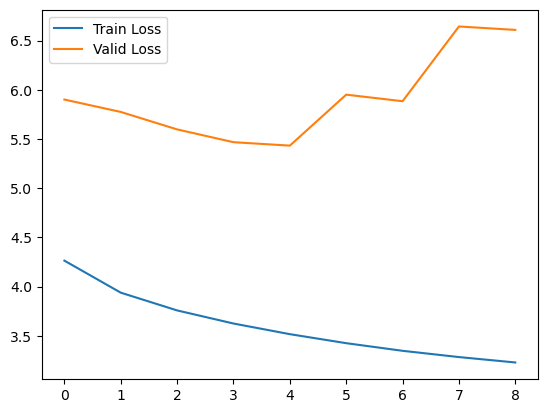

In [92]:
# plot the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.legend()

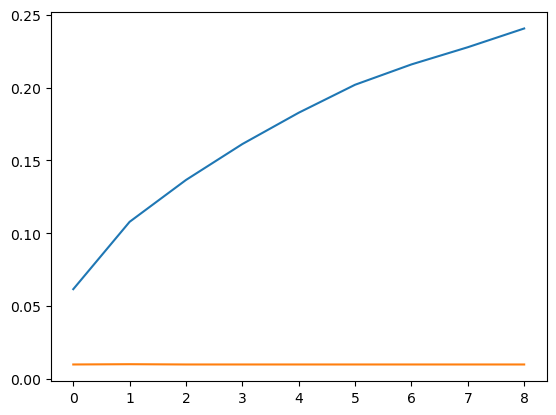

In [93]:
# plot the accuracies
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Valid Accuracy")

In [94]:
print(valid_accuracies)

[0.009900990099009901, 0.01008958038661009, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901]


In [100]:
# model.eval()
model.train()
# TODO : WARNING with batch norm between train and eval, eval seems to break the model

for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        # compute the accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        print(accuracy.item())
        


0.0
0.0
0.0
0.03125
0.03125
0.0
0.09375
0.0625
0.0625
0.03125
0.0
0.03125
0.0
0.03125
0.0
0.0
0.09375
0.125
0.03125
0.25
0.0
0.0625
0.0
0.03125
0.0625
0.0625
0.15625
0.0
0.0
0.0
0.0
0.0625
0.125
0.0625
0.09375
0.125
0.0625
0.0625
0.03125
0.09375
0.0
0.09375
0.1875
0.0
0.03125
0.0625
0.03125
0.0
0.03125
0.09375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03125
0.0
0.0
0.0
0.0
0.09375
0.0
0.0
0.1875
0.125
0.0625
0.15625
0.0
0.0
0.0
0.0
0.0
0.0
0.03125
0.0
0.0
0.0625
0.03125
0.0625
0.03125
0.03125
0.0
0.0
0.03125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03125
0.0625
0.125
0.0
0.03125
0.15625
0.03125
0.0
0.0
0.03125
0.15625
0.15625
0.0
0.0
0.0
0.15625
0.03125
0.0625


KeyboardInterrupt: 

In [27]:
from pathlib import Path
import json

path = Path("test_run")
class_metrics = None
with open(path / "class_metrics.json") as f:
    class_metrics = json.load(f)

print(class_metrics)


{'accuracy': [0.0, 0.02, 0.048, 0.052, 0.0, 0.08, 0.472, 0.104, 0.012, 0.0, 0.04, 0.36, 0.012, 0.364, 0.008, 0.0, 0.0, 0.004, 0.076, 0.0, 0.152, 0.268, 0.0, 0.056, 0.268, 0.0, 0.0, 0.0, 0.012, 0.028, 0.0, 0.0, 0.032, 0.476, 0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.008, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.004, 0.148, 0.0, 0.032, 0.184, 0.0, 0.0, 0.148, 0.008, 0.0, 0.02, 0.0, 0.084, 0.216, 0.044, 0.088, 0.0, 0.056, 0.196, 0.0, 0.012, 0.132, 0.076, 0.236, 0.056, 0.0, 0.048, 0.1, 0.116, 0.0, 0.004, 0.02, 0.092, 0.0, 0.032, 0.0, 0.416, 0.156, 0.0, 0.032, 0.0, 0.156, 0.0, 0.248, 0.42, 0.0, 0.0, 0.108, 0.004, 0.0, 0.0, 0.0, 0.004, 0.004], 'recall': [0.0, 0.01999999992, 0.047999999808, 0.051999999792, 0.0, 0.07999999968, 0.471999998112, 0.103999999584, 0.011999999952, 0.0, 0.03999999984, 0.35999999856000003, 0.011999999952, 0.363999998544, 0.007999999968, 0.0, 0.0, 0.003999999984, 0.075999999696, 0.0, 0.151999999392, 0.267999998928, 0.0, 0.055999999776, 0.267999998928, 0.0, 0.0, 0.0, 0.011999999952, 0.

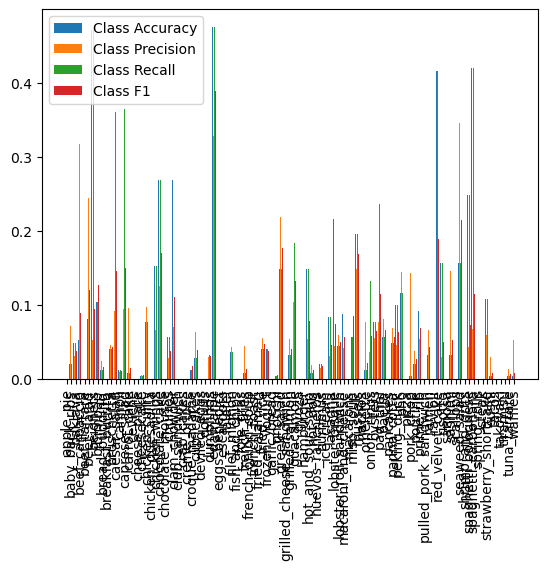

In [28]:
# we do a bar plot of the class accuracies
import matplotlib.pyplot as plt
import numpy as np

class_accuracies = class_metrics["accuracy"]
class_precision = class_metrics["precision"]
class_recall = class_metrics["recall"]
class_f1 = class_metrics["f1_score"]
clas = class_metrics["class_names"]


fig, ax = plt.subplots()
bar_width = 0.2
x = np.arange(len(class_accuracies))
ax.bar(x, class_accuracies, bar_width, label='Class Accuracy')
ax.bar(x + bar_width, class_precision, bar_width, label='Class Precision')
ax.bar(x + 2*bar_width, class_recall, bar_width, label='Class Recall')
ax.bar(x + 3*bar_width, class_f1, bar_width, label='Class F1')
ax.set_xticks(x + 2*bar_width)
ax.set_xticklabels(clas, rotation=90)
ax.legend()




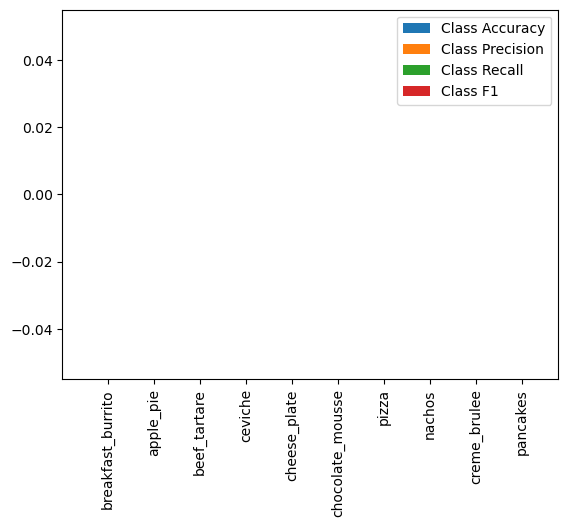

In [29]:
sorted_acc_idx = np.argsort(class_accuracies)
sorted_acc = np.array(class_accuracies)[sorted_acc_idx]
sorted_clas = np.array(clas)[sorted_acc_idx]
sorted_precision = np.array(class_precision)[sorted_acc_idx]
sorted_recall = np.array(class_recall)[sorted_acc_idx]
sorted_f1 = np.array(class_f1)[sorted_acc_idx]

n_to_plot = 10
idxes = np.arange(n_to_plot)
# plot the n_to_plot worst classes
fig, ax = plt.subplots()
bar_width = 0.2
x = np.arange(n_to_plot)
ax.bar(x, sorted_acc[idxes], bar_width, label='Class Accuracy')
ax.bar(x + bar_width, sorted_precision[idxes], bar_width, label='Class Precision')
ax.bar(x + 2*bar_width, sorted_recall[idxes], bar_width, label='Class Recall')
ax.bar(x + 3*bar_width, sorted_f1[idxes], bar_width, label='Class F1')
ax.set_xticks(x + 2*bar_width)
ax.set_xticklabels(sorted_clas[idxes], rotation=90)
ax.legend()


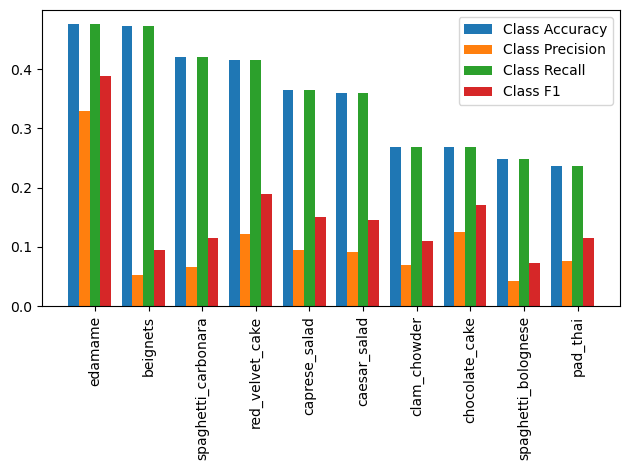

In [30]:
# plot the n_to_plot best classes

idxes = np.arange(len(class_accuracies) - n_to_plot, len(class_accuracies))
idxes = np.flip(idxes)

fig, ax = plt.subplots()
bar_width = 0.2
x = np.arange(n_to_plot)
ax.bar(x, sorted_acc[idxes], bar_width, label='Class Accuracy')
ax.bar(x + bar_width, sorted_precision[idxes], bar_width, label='Class Precision')
ax.bar(x + 2*bar_width, sorted_recall[idxes], bar_width, label='Class Recall')
ax.bar(x + 3*bar_width, sorted_f1[idxes], bar_width, label='Class F1')
ax.set_xticks(x + 2*bar_width)
ax.set_xticklabels(sorted_clas[idxes], rotation=90)
# avoid overlapping of the bars
fig.tight_layout()


ax.legend()


In [22]:
# load confusion matrix
with open(path / "confusion_matrix.json") as f:
    confusion_matrix = json.load(f)

Text(220.72222222222223, 0.5, 'Predicted')

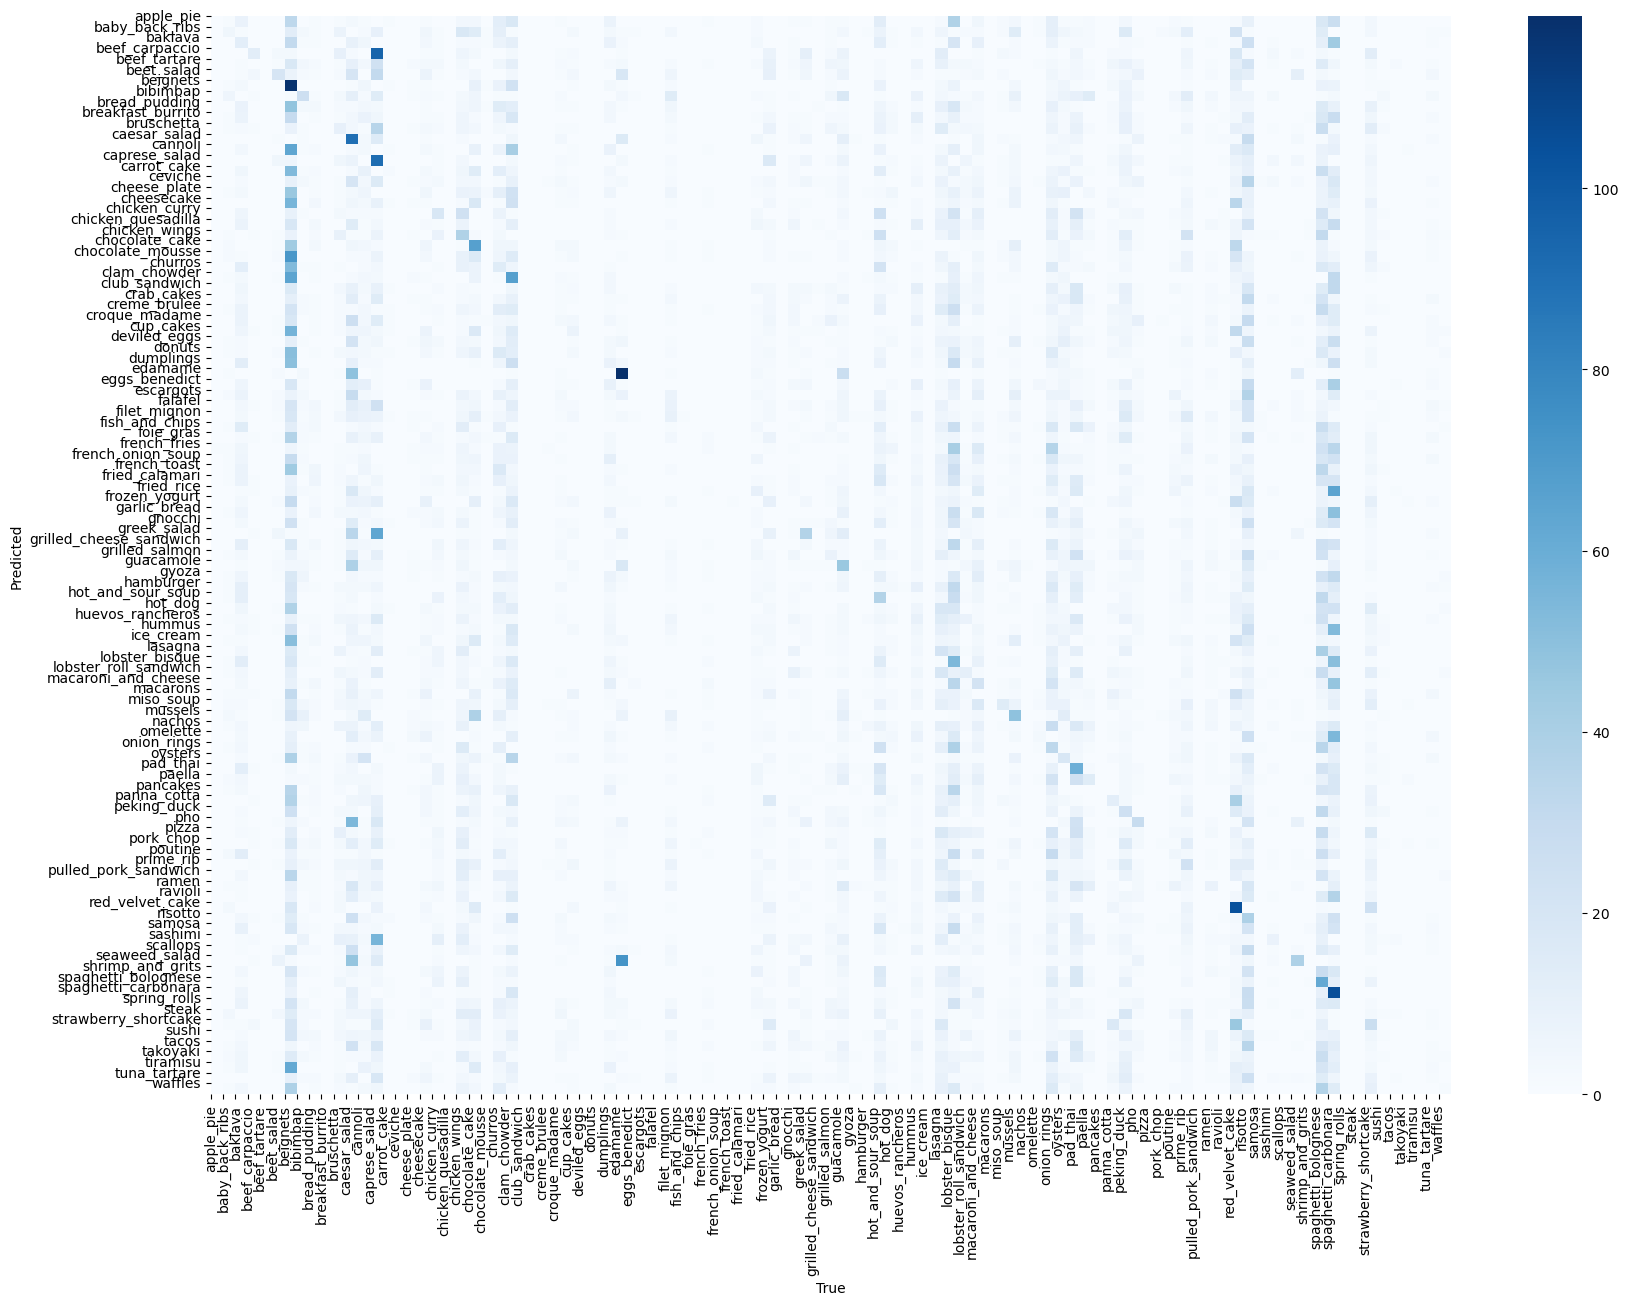

In [32]:
# plot the confusion matrix
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (20,14))
sns.heatmap(df_cm, annot=False, cmap='Blues', fmt='g')
# add tick names
plt.xticks(np.arange(len(clas)), clas, rotation=90)
plt.yticks(np.arange(len(clas)), clas, rotation=0)

# add labels true and predicted
plt.xlabel("True")
plt.ylabel("Predicted")
